# Predict future sales
In this competition you will work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company. 

We are asking you to predict total sales for every product and store in the next month. By solving this competition you will be able to apply and enhance your data science skills.

In [1]:
import pandas as pd
import numpy as np
import pickle
import os
import gc
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import save_npz, load_npz, hstack, vstack
from sklearn.feature_extraction.text import TfidfVectorizer
%matplotlib inline 

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)

import lightgbm as lgb
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
from tqdm import tqdm_notebook

from itertools import product
import warnings

In [2]:
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [3]:
DATA_FOLDER = '../readonly/final_project_data/'

sales    = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv.gz'))
items           = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops           = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))
train           = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv.gz'), compression='gzip')
test           = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv'))

# EDA

I check the size of the data

In [4]:
print ('sales shape %s' % np.str(sales.shape))
print ('items shape %s' % np.str(items.shape))
print ('item_categories shape %s' % np.str(item_categories.shape))
print ('shops shape %s' % np.str(shops.shape))
print ('train shape %s' % np.str(train.shape))
print ('test shape %s' % np.str(test.shape))

sales shape (2935849, 6)
items shape (22170, 3)
item_categories shape (84, 2)
shops shape (60, 2)
train shape (2935849, 6)
test shape (214200, 3)


I give a 1st look at the data.
Sales & Train have the same shape. Are the same df?

In [5]:
sales.equals(train)

True

In [6]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [7]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [8]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [9]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [10]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


so I need to predict the shop sales, which in this case means predicting the sales of the combination of shop & product, not just the total shop sales

1st I add the descriptions to shops & categories in the sales df

In [11]:
items_merge = pd.merge(left = items, right = item_categories , left_on = 'item_category_id', right_on = 'item_category_id')

In [12]:
sales_merge = pd.merge(left = sales,right = shops, left_on ='shop_id', right_on = 'shop_id' )
sales_merge = pd.merge(left = sales_merge,right = items_merge, left_on ='item_id', right_on = 'item_id' )

In [13]:
sales_merge.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
0,02.01.2013,0,59,22154,999.0,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,02.01.2013,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
2,03.01.2013,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
3,20.01.2013,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
4,23.01.2013,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray


i check the types of the cols

In [14]:
sales_merge.dtypes

date                   object
date_block_num          int64
shop_id                 int64
item_id                 int64
item_price            float64
item_cnt_day          float64
shop_name              object
item_name              object
item_category_id        int64
item_category_name     object
dtype: object

daily sales is float. Are there any partial sales?

In [15]:
(sales_merge.item_cnt_day%1 != 0).any()

False

Are there any NaNs?

In [16]:
sales_merge.isnull().values.any()

False

Are there zero sales?

In [17]:
sales_merge[sales_merge['item_cnt_day']==0]['item_cnt_day'].sum()

0

There are no occurrences of zero sales in the df

In [18]:
test.isnull().values.any()

False

So all cells have been populated with some values

Does each item belong just to one category?

In [19]:
len(items_merge.groupby(['item_name','item_category_name']).nunique()) == len(items_merge)

True

Now let's have a look how train & test are constructed

In [20]:
set(sales_merge.shop_id) - set(test.shop_id)

{0, 1, 8, 9, 11, 13, 17, 20, 23, 27, 29, 30, 32, 33, 40, 43, 51, 54}

All shops in the test set are also in the train set. 

In [21]:
len(set(test.item_id) - set(sales_merge.item_id))

363

Merda! 363 items have been placed in the test set but they have never been observed in the train set... 
this can be an hint that the test set has been artificially constructed.

In [22]:
len(test.groupby(['shop_id','item_id']))

214200

In [23]:
len(set(test.item_id)) * len(set(test.shop_id))

214200

Hypo confirmed. The test set has been made by combining a set of items with a set of shops.
I can expect that there will be zero sales for many shop-item combinations.

I will have to add the zero lines with all combinations of shop & item in the train set too to align it with test set. 
Why? Because any model trained on the original train set would never predict zero sales as there are no zero sales in the training set.
The accuracy on the test set will then be very low as in this set zero sales are expected.

Now what I would like to do is try to understand whether there was a logic in the selection of the items/shops

In [24]:
add_items_test = set(test.item_id) - set(sales_merge.item_id)

In [25]:
items_merge.loc[add_items_test].sort_values(['item_category_name'])

,item_name,item_id,item_category_id,item_category_name
20439,Universal: Кабель оптический Gioteck XC-6 цифр...,7235,3,Аксессуары - PS4
20378,PS Vita 1000: Крышка Hori Face Cover защитная ...,5579,5,Аксессуары - PSVita
20400,PS Vita: Чехол 4gamers Clean 'n' Protect мягки...,5601,5,Аксессуары - PSVita
20403,PS Vita: Чехол 4gamers Travel Case дорожный кр...,5604,5,Аксессуары - PSVita
20401,PS Vita: Чехол 4gamers Deluxe Travel Case доро...,5602,5,Аксессуары - PSVita
20461,X360: Файтстик Hori Fighting Edge (HX3-70U),7896,6,Аксессуары - XBOX 360
20476,Аксессуар: Xbox 360 Жесткий диск 500 ГБ (6FM-0...,8448,6,Аксессуары - XBOX 360
20677,Комплект Sony PS3 (320 GB) (CECH-3008B) + игра...,13433,11,Игровые консоли - PS3
20680,Комплект Sony PS3 Super Slim (12 Gb) (CECH-400...,13436,11,Игровые консоли - PS3
21974,Игровая приставка SEGA Genesis Nano Trainer (б...,12126,17,Игровые консоли - Прочие


In [26]:
items_merge.loc[add_items_test].sort_values(['item_name'])

,item_name,item_id,item_category_id,item_category_name
13338,1С:Аудиокниги. Английский за рулем. Выпуск 2 (...,155,45,Книги - Аудиокниги 1С
13209,1С:Аудиокниги. Вагин И. О. Как перестать нервн...,186,44,Книги - Аудиокниги (Цифра)
13231,1С:Аудиокниги. Гранатовый браслет [Цифровая ве...,220,44,Книги - Аудиокниги (Цифра)
13232,1С:Аудиокниги. Грин А.С. Алые паруса [Цифровая...,221,44,Книги - Аудиокниги (Цифра)
13242,1С:Аудиокниги. Е. Сивков. Притчи и анекдоты [...,245,44,Книги - Аудиокниги (Цифра)
13249,"1С:Аудиокниги. Кириллов К., Обердерфер Д. Как ...",261,44,Книги - Аудиокниги (Цифра)
13250,"1С:Аудиокниги. Кириллов К., Обердерфер Д. Как ...",262,44,Книги - Аудиокниги (Цифра)
13251,1С:Аудиокниги. Классика русского юмора. Юморис...,266,44,Книги - Аудиокниги (Цифра)
13392,1С:Аудиокниги. Коллекция страшилок-смешилок дл...,270,45,Книги - Аудиокниги 1С
13394,1С:Аудиокниги. Кот-наоборот. Стихи для детског...,273,45,Книги - Аудиокниги 1С


* Items belong to one of the following categories: 
console games, PC games, console/PC accessories, Movies, Music, eBooks & SW & merchandise related to games/video

* I will need to extract text feature to help the model exploit the info in the products

In [27]:
items_merge.loc[add_items_test].sort_values(['item_id'])

,item_name,item_id,item_category_id,item_category_name
13338,1С:Аудиокниги. Английский за рулем. Выпуск 2 (...,155,45,Книги - Аудиокниги 1С
13209,1С:Аудиокниги. Вагин И. О. Как перестать нервн...,186,44,Книги - Аудиокниги (Цифра)
13231,1С:Аудиокниги. Гранатовый браслет [Цифровая ве...,220,44,Книги - Аудиокниги (Цифра)
13232,1С:Аудиокниги. Грин А.С. Алые паруса [Цифровая...,221,44,Книги - Аудиокниги (Цифра)
13242,1С:Аудиокниги. Е. Сивков. Притчи и анекдоты [...,245,44,Книги - Аудиокниги (Цифра)
13249,"1С:Аудиокниги. Кириллов К., Обердерфер Д. Как ...",261,44,Книги - Аудиокниги (Цифра)
13250,"1С:Аудиокниги. Кириллов К., Обердерфер Д. Как ...",262,44,Книги - Аудиокниги (Цифра)
13251,1С:Аудиокниги. Классика русского юмора. Юморис...,266,44,Книги - Аудиокниги (Цифра)
13392,1С:Аудиокниги. Коллекция страшилок-смешилок дл...,270,45,Книги - Аудиокниги 1С
13394,1С:Аудиокниги. Кот-наоборот. Стихи для детског...,273,45,Книги - Аудиокниги 1С


Items are ordered by their 1st letter & there seem to be 2 main groups

TO DO: Count Items by 1st letter & category & investigate further

Now let's start visualize the data

In [28]:
sales_eda = sales_merge.copy()

1.Add details about weeks, days of week etc...

In [29]:
import datetime as dt
sales_eda['date'] = pd.to_datetime(sales_eda['date'],format='%d.%m.%Y')
sales_eda['nr_dow'] = sales_eda.date.dt.weekday
sales_eda['month'] = sales_eda.date.dt.month
sales_eda['year'] = sales_eda.date.dt.year

In [30]:
sales_eda.sort_values(['date'], inplace=True)
sales_eda.reset_index(drop=True, inplace=True)

In [31]:
sales_eda['date_block_num'].max()

33

1.plot raw sales over time

([<matplotlib.axis.XTick at 0x1fd0048feb8>,
 <a list of 34 Text xticklabel objects>)

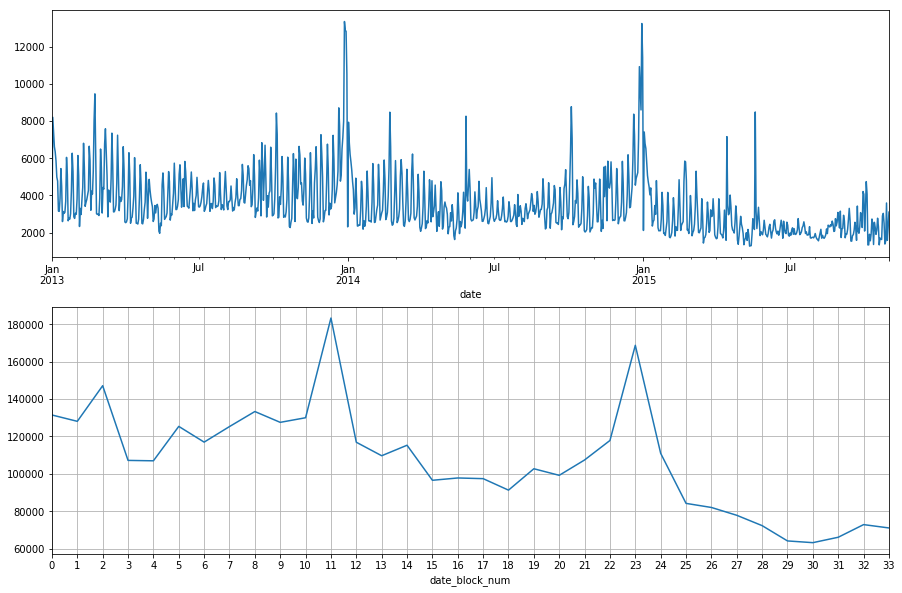

In [32]:
plt.figure(figsize=(15,10))
ax = plt.subplot(211)
sales_eda.groupby('date').item_cnt_day.sum().plot(ax=ax)
ax = plt.subplot(212)
sales_eda.groupby('date_block_num').item_cnt_day.sum().plot(ax=ax)
plt.grid(True)
plt.xticks(np.arange(34))

Observations:
* spikes in Dec = shopping for Xmas, though this is celebrated in Jan
* there seems to be trend over the years
* total sales are going down over the years

Now I check the dates span

In [33]:
dates_df = pd.to_datetime(sales_eda['date'],format='%d.%m.%Y')
print ('Sale from %s to %s' % (str(dates_df.min()),str(dates_df.max())))

Sale from 2013-01-01 00:00:00 to 2015-10-31 00:00:00


I want to predict the sales in November 2015.

Though I know that the test set has been artificially generated, 

I am going to plot Nov 2013 & Nov 2014 to check whether they can be good candidates as valitation sets.

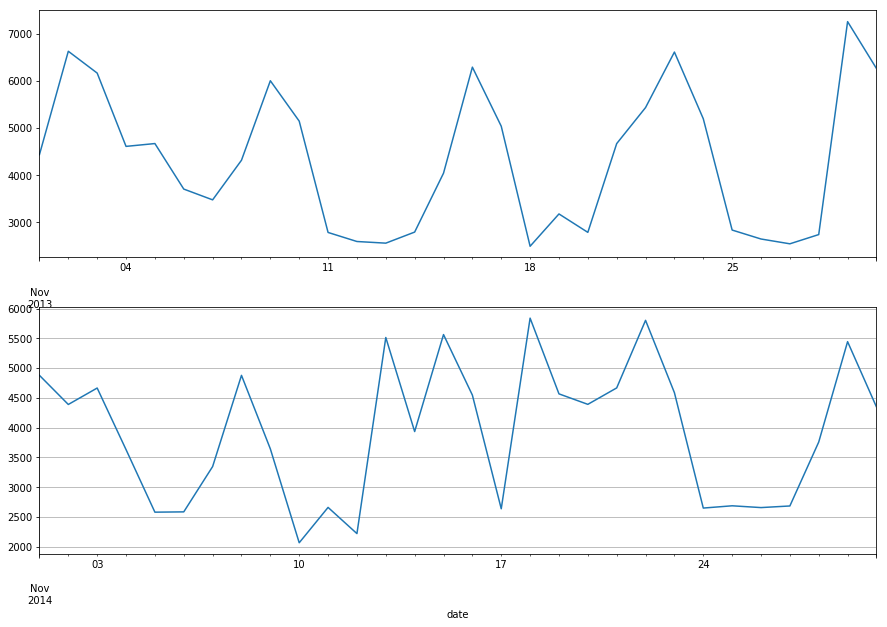

In [34]:
plt.figure(figsize=(15,10))
ax = plt.subplot(211)
sales_eda[sales_eda['date_block_num'] == 10].groupby('date').item_cnt_day.sum().plot(ax=ax)
ax = plt.subplot(212)
sales_eda[sales_eda['date_block_num'] == 22].groupby('date').item_cnt_day.sum().plot(ax=ax)
plt.grid(True)
#plt.xticks(np.arange(31))

Mah...not really helpful

Now I am going to plot the sales per month across the years

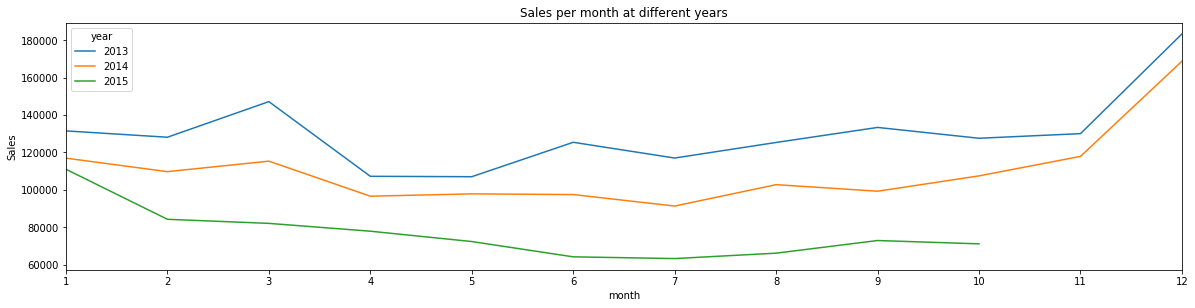

In [35]:
plt.figure(figsize=(20,10))
ax = plt.subplot(211)
sales_eda.groupby(['year', 'month']).item_cnt_day.sum().unstack(level=0).plot(ax=ax)
plt.xlim(1, 12)
plt.xticks(range(1, 13))
plt.title('Sales per month at different years')
plt.ylabel('Sales');

* Sales are decreasing
* We can see the trend in the years

Now I look for the sales during the weeksdays over the months.

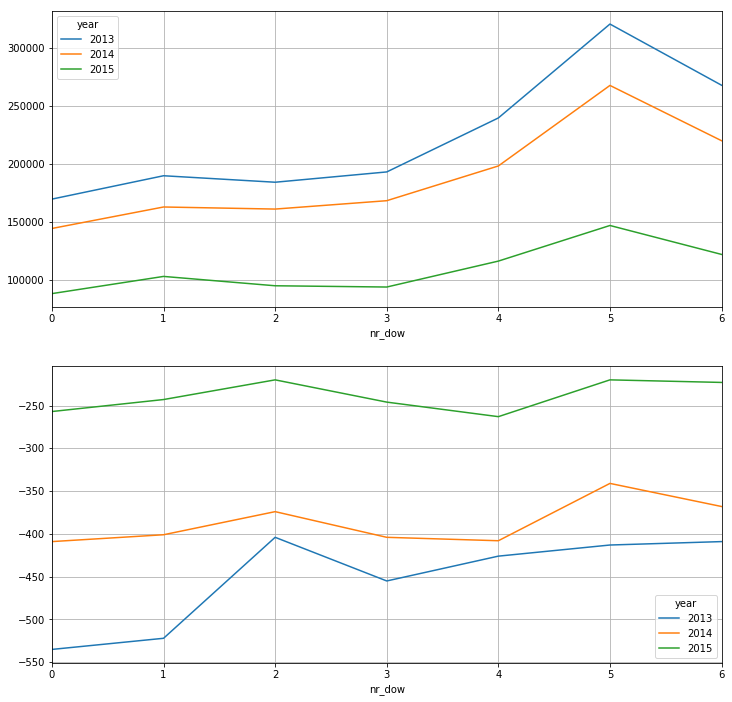

In [36]:
plt.figure(figsize=(12,12))
ax = plt.subplot(211)
sales_eda[sales_eda['item_cnt_day'] >= 0].groupby(['year', 'nr_dow']).item_cnt_day.sum().unstack(level=0).plot(ax=ax)
plt.grid(True)
ax = plt.subplot(212)
sales_eda[sales_eda['item_cnt_day'] < 0].groupby(['year', 'nr_dow']).item_cnt_day.sum().unstack(level=0).plot(ax=ax)
plt.grid(True)

* Most sales happen on saturdays
* Most returns on Mondays

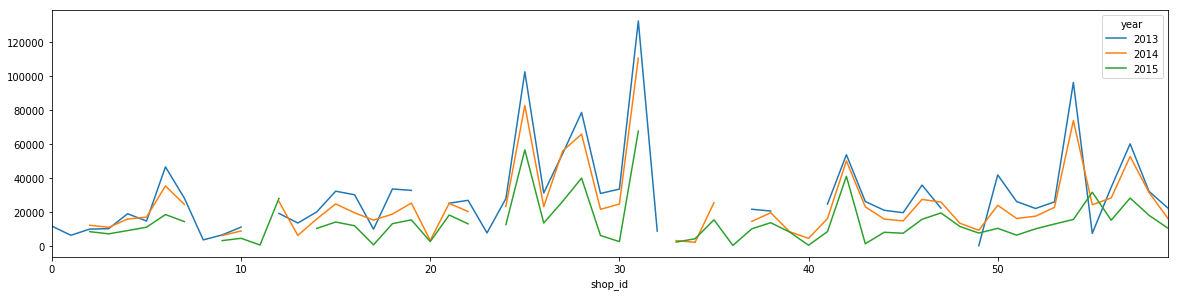

In [37]:
plt.figure(figsize=(20,10))
ax = plt.subplot(211)
sales_eda.groupby(['year','shop_id']).item_cnt_day.sum().unstack(level=0).plot(ax=ax)
#plt.grid(True)

Interesting - shops open & close over time. I need then to add the zero sales for these cases.

We can see that it seems that shops maintain the same sales performances over the years.

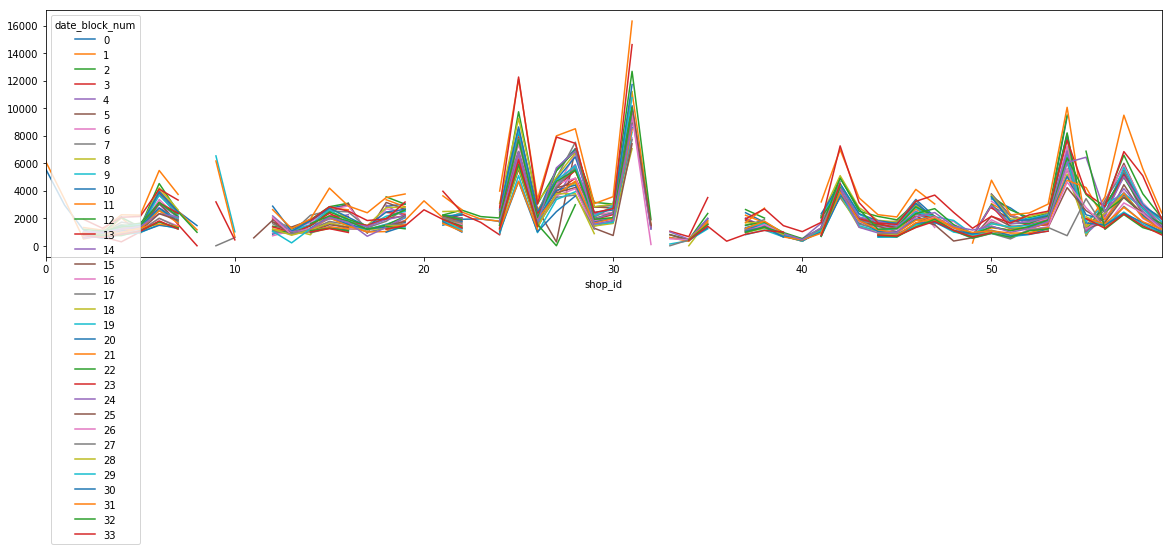

In [38]:
plt.figure(figsize=(20,10))
ax = plt.subplot(211)
sales_eda.groupby(['date_block_num','shop_id']).item_cnt_day.sum().unstack(level=0).plot(ax=ax)
#plt.grid(True)

it looks like shops show regularity in performance over time. To be captured in feature generation

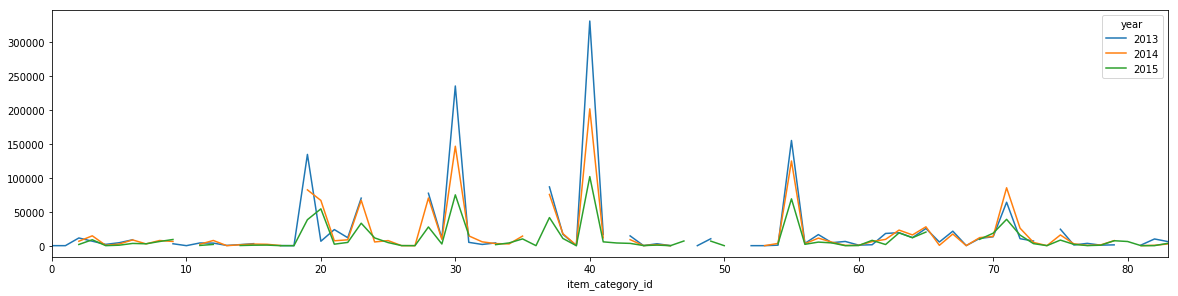

In [39]:
plt.figure(figsize=(20,10))
ax = plt.subplot(211)
sales_eda.groupby(['year','item_category_id']).item_cnt_day.sum().unstack(level=0).plot(ax=ax)
#plt.grid(True)

There seem to be a bunch of shops & categories with very high sales

Now I look for outliers.
Shop & Category sales spikes are consistent over the years, I will then not look into them further for the time being.
I check the product sales per product id

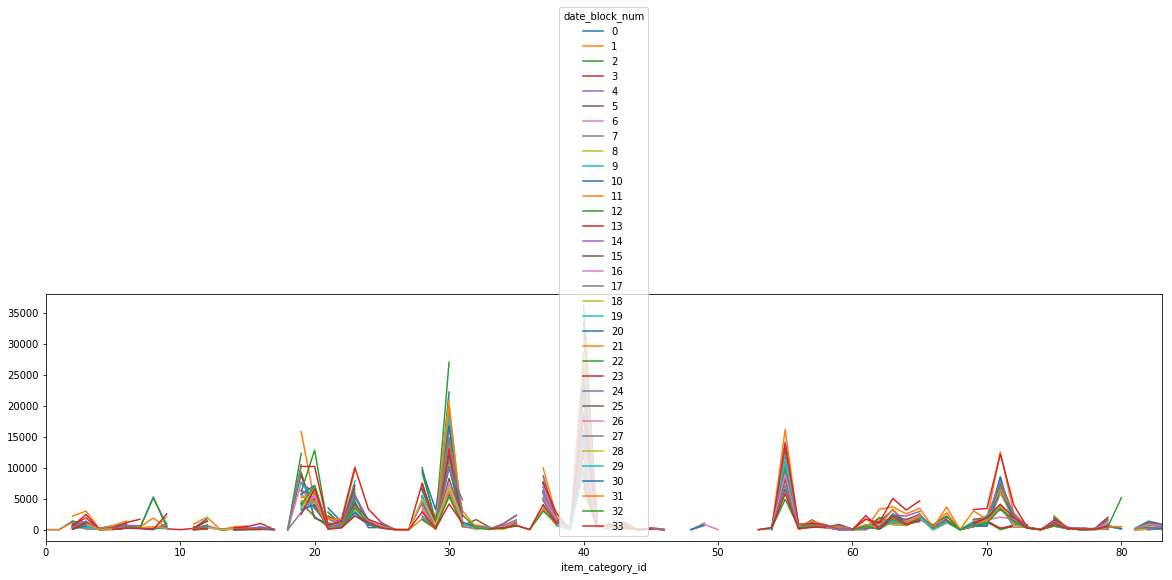

In [40]:
plt.figure(figsize=(20,10))
ax = plt.subplot(211)
sales_eda.groupby(['date_block_num','item_category_id']).item_cnt_day.sum().unstack(level=0).plot(ax=ax)
#plt.grid(True)

same for categories - there is regularity over time

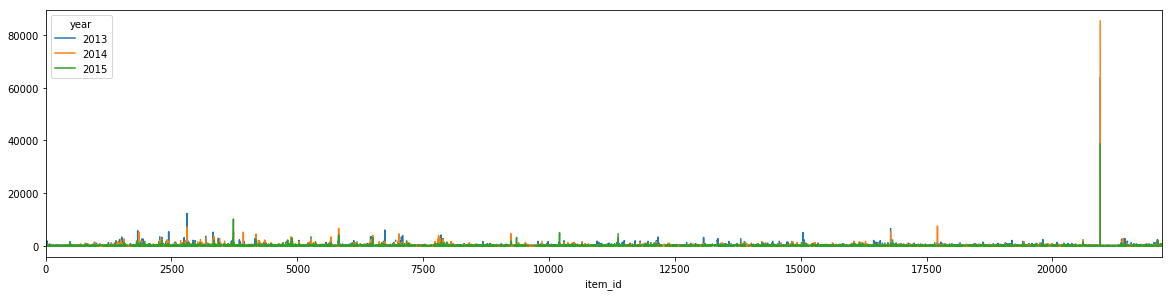

In [41]:
plt.figure(figsize=(20,10))
ax = plt.subplot(211)
item_sales = sales_eda.groupby(['year','item_id']).item_cnt_day.sum()
item_sales.unstack(level=0).plot(ax=ax)

Let's look at the product with the highest sales

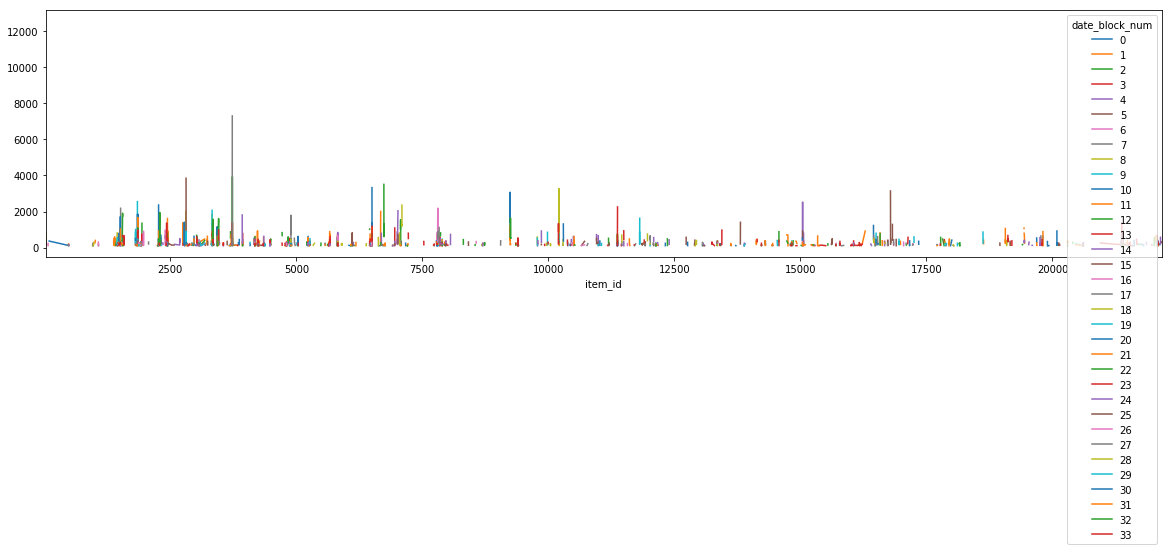

In [42]:
plt.figure(figsize=(20,10))
ax = plt.subplot(211)
item_sales = sales_eda.groupby(['date_block_num','item_id']).item_cnt_day.sum()
item_sales[item_sales.values > 100].unstack(level=0).plot(ax=ax)

In [43]:
item_sales.head()

date_block_num  item_id
0               19           1.0
                27           7.0
                28           8.0
                29           4.0
                32         299.0
Name: item_cnt_day, dtype: float64

In [44]:
top_prod = item_sales[item_sales.values > 20000]

In [45]:
top_prod

Series([], Name: item_cnt_day, dtype: float64)

In [46]:
items_merge[items_merge.item_id.isin(list(top_prod.index.get_level_values(level=1)))]

,item_name,item_id,item_category_id,item_category_name


it is a shopping bag.

# Feature Generation

In [47]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


### Aggregate data

Since the competition task is to make a monthly prediction, we need to aggregate the data to montly level before doing any encodings. 

In [48]:
def aggr_train(sales):
    index_cols = ['shop_id', 'item_id', 'date_block_num']
    # For every month we create a grid from all shops/items combinations from that month
    grid = [] 
    for block_num in sales['date_block_num'].unique():
        cur_shops = sales[sales['date_block_num']==block_num]['shop_id'].unique()
        cur_items = sales[sales['date_block_num']==block_num]['item_id'].unique()
        grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))
 
    #turn the grid into pandas dataframe
    grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)
    
    #get aggregated values for (shop_id, item_id, month)
    gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})

    #fix column names
    gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
    #join aggregated data to the grid
    all_data = pd.merge(grid,gb,how='left',on=index_cols).fillna(0)
    #sort the data
    #all_data.sort_values(['date_block_num','shop_id','item_id'],inplace=True) 
    all_data.reset_index(inplace=True, drop=True)
    all_data.target = all_data.target.astype(np.float32)
       
    return all_data 

In [49]:
train_df = aggr_train(sales)

C:\Users\User\Anaconda3\lib\site-packages\pandas\core\groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [50]:
train_df.head()

,shop_id,item_id,date_block_num,target
0,59,22154,0,1.0
1,59,2552,0,0.0
2,59,2554,0,0.0
3,59,2555,0,0.0
4,59,2564,0,0.0


Add item category ID

In [51]:
train_df['item_category_id'] = train_df['item_id'].map(items['item_category_id']).astype(np.int32)
test['item_category_id'] = test['item_id'].map(items['item_category_id']).astype(np.int32)

In [52]:
train_df.head()

,shop_id,item_id,date_block_num,target,item_category_id
0,59,22154,0,1.0,37
1,59,2552,0,0.0,58
2,59,2554,0,0.0,58
3,59,2555,0,0.0,56
4,59,2564,0,0.0,59


### Lagged features

In [53]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [54]:
gc.collect();
from tqdm import tqdm_notebook

index_cols = ['shop_id', 'item_id', 'date_block_num']
test_index_cols = ['shop_id', 'item_id']
cols_to_rename = ['target']

shift_range = [1, 2, 3, 6, 12]

train_df = downcast_dtypes(train_df)
test = downcast_dtypes(test)

for month_shift in tqdm_notebook(shift_range):
    print("passa %s\n" % str(month_shift))
    train_shift = train_df[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)
    
    train_df = pd.merge(train_df, train_shift, on=index_cols, how='left').fillna(0)
    
    # Test
    test_month_shift = 34 - month_shift
    test_shift = train_df.loc[train_df.date_block_num == test_month_shift, test_index_cols + cols_to_rename].copy()
    test_shift = test_shift.rename(columns=foo)
    
    test = pd.merge(test, test_shift, on=test_index_cols, how='left').fillna(0)

lagged_features = [col for col in train.columns if 'lag' in col]
del train_shift, test_shift   
gc.collect();

A Jupyter Widget

passa 1

passa 2

passa 3

passa 6

passa 12




### Text features

In [55]:
#create tfidfs
train_tf_idf_features = {}
test_tf_idf_features = {}
col_vals = [shops.shop_name, items.item_name]
col_names = ['shop_id', 'item_id']

fName = "shop_id_tf_idf_train.npz"

if os.path.exists(fName):
    print('Loading text features...')
    for name in col_names:
        train_tf_idf_features[name] = load_npz(name + '_tf_idf_train.npz')
        test_tf_idf_features[name] = load_npz(name + '_tf_idf_test.npz')
else:
    print('Generate text features...')
    #load russian + relevant english stopwords
    stop_words_ru= ['для','тц', 'тк', 'трк', 'трц', 'ii', 'ул', 'пав','the', 'для', 'of', 'на']
    
    for name, text in zip(col_names, col_vals):
        print(f'Tfidf from feature {name}')
        tfidf_vectorizer = TfidfVectorizer(max_features=30, stop_words=stop_words_ru)
        tf_idf_feats = tfidf_vectorizer.fit_transform(text)

        means = np.array(tf_idf_feats.mean(axis=0)).squeeze()
        argsort = means.argsort()
        print('Top frequency words:')
        print(np.array(tfidf_vectorizer.get_feature_names())[argsort[::-1][:30]])
        print()

        # Create and save
        print('Transform data')
        sparse_text_train = tfidf_vectorizer.transform(train_df[name].map(text))
        sparse_text_test = tfidf_vectorizer.transform(test[name].map(text))
        train_tf_idf_features[name] = sparse_text_train
        test_tf_idf_features[name] = sparse_text_test
        
        print('Save to file')
        save_npz(name + '_tf_idf_train', sparse_text_train)
        save_npz(name + '_tf_idf_test', sparse_text_test)
        print()
print ("...done")

Loading text features...
...done


In [56]:
train_tf_idf_features['item_id'].toarray().nonzero()

(array([       0,        1,        2, ..., 10913849, 10913849, 10913849],
       dtype=int64), array([ 4, 10, 10, ...,  5,  9, 11], dtype=int64))

In [57]:
train_df.head()

,shop_id,item_id,date_block_num,target,item_category_id,target_lag_1,target_lag_2,target_lag_3,target_lag_6,target_lag_12
0,59,22154,0,1.0,37,0.0,0.0,0.0,0.0,0.0
1,59,2552,0,0.0,58,0.0,0.0,0.0,0.0,0.0
2,59,2554,0,0.0,58,0.0,0.0,0.0,0.0,0.0
3,59,2555,0,0.0,56,0.0,0.0,0.0,0.0,0.0
4,59,2564,0,0.0,59,0.0,0.0,0.0,0.0,0.0


In [58]:
test.head()

,ID,shop_id,item_id,item_category_id,target_lag_1,target_lag_2,target_lag_3,target_lag_6,target_lag_12
0,0,5,5037,19,0.0,1.0,3.0,1.0,1.0
1,1,5,5320,55,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,19,1.0,3.0,1.0,3.0,0.0
3,3,5,5232,23,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,20,0.0,0.0,0.0,0.0,0.0


### Mean Encodings

In [59]:
def expand_mean_enc(tr, test, col,global_mean):
    new_col_name = col + '_enc'
    tr[new_col_name] = np.nan

    cumsum = tr.groupby(col)['target'].cumsum() - tr['target']
    cumcount = tr.groupby(col)['target'].cumcount()

    expanding_mean = pd.DataFrame({'expand_mean': cumsum / cumcount,
                                   'date_block_num': tr.date_block_num,
                                   col: tr[col]})
    for block_num in np.unique(tr.date_block_num)[1:]:
        cur_mask = tr.date_block_num == block_num
        prev_mask = tr.date_block_num <= block_num - 1
        
        mapping = expanding_mean[prev_mask].groupby(col).expand_mean.last()
        tr.loc[cur_mask, new_col_name] = tr.loc[cur_mask, col].map(mapping)
        
    
    # Fill train with last seen values from train
    prev_mask = tr.date_block_num <= tr.date_block_num.max()
    mapping = expanding_mean[prev_mask].groupby(col).expand_mean.last()
    test[new_col_name] = test[col].map(mapping)
    
    # Downcast
    tr[new_col_name] = tr[new_col_name].astype(np.float32)
    test[new_col_name] = test[new_col_name].astype(np.float32)
    
    # Fill NaNs
    tr[new_col_name].fillna(global_mean, inplace=True) 
    tr[new_col_name].replace(np.inf, global_mean, inplace=True)

    test[new_col_name].fillna(global_mean, inplace=True) 
    test[new_col_name].replace(np.inf, global_mean, inplace=True)
    return tr,test

In [60]:
col_4_mean = ['item_id','shop_id','item_category_id']
global_mean = train_df.target.mean()

In [61]:
for col in col_4_mean:
    train_df, test = expand_mean_enc(train_df, test, col,global_mean)

In [62]:
train_df.loc[np.random.choice(train_df.index,10,replace=False)]

,shop_id,item_id,date_block_num,target,item_category_id,target_lag_1,target_lag_2,target_lag_3,target_lag_6,target_lag_12,item_id_enc,shop_id_enc,item_category_id_enc
7933368,14,8497,22,0.0,43,0.0,0.0,0.0,0.0,0.0,0.222973,0.196392,0.093687
2271225,27,21607,6,1.0,40,0.0,0.0,1.0,0.0,0.0,0.109890,0.470008,0.270156
5802955,30,20197,15,0.0,49,0.0,0.0,0.0,0.0,0.0,0.021583,0.336819,0.224822
1634631,46,20179,4,1.0,69,0.0,0.0,0.0,0.0,0.0,0.439560,0.344832,0.235556
9014569,26,8121,25,0.0,55,0.0,0.0,0.0,0.0,1.0,0.159359,0.303286,0.226362
10449024,25,16360,31,1.0,69,6.0,3.0,4.0,3.0,0.0,0.943089,1.031149,0.288602
9384017,54,4383,27,0.0,62,0.0,0.0,0.0,0.0,0.0,0.042945,0.939347,0.196565
1657252,35,4510,4,1.0,55,0.0,0.0,0.0,0.0,0.0,0.197802,0.267194,0.202814
8976883,11,22013,25,0.0,38,0.0,0.0,0.0,0.0,0.0,0.040426,0.334273,0.192910
2231552,43,12782,5,0.0,41,0.0,0.0,0.0,0.0,0.0,0.427313,0.238629,0.201374


### Test data leakage

How was the test set created?

We pick all unique values of shop_id and item_id for certain month and find their combination. 
This combination is not at random, it takes unique item_ids for each shop_id repeatedly. 
The list is not shuffled.
The later item_id appear for a certain month, the lesser sales it will have. There it is, frequent item_ids come first.

In [63]:
#train set
counts_mapping = train_df.groupby(['date_block_num', 'shop_id']).shop_id.count()
counts = pd.Series(list(zip(train_df.date_block_num, train_df.shop_id))).map(counts_mapping)
train_df['shops_index'] = (train_df.groupby(['date_block_num', 'shop_id']).shop_id.cumcount() / counts).astype(np.float32)
    
#test set
counts_mapping = test.groupby('shop_id').shop_id.count()
counts = test.shop_id.map(counts_mapping)
test['shops_index'] = (test.groupby('shop_id').shop_id.cumcount() / counts).astype(np.float32)

In [64]:
FEATURE_ITEM_ID_FREQS = 'item_id_freqs'
def create_item_id_freqs(tr, test, new_col=FEATURE_ITEM_ID_FREQS):
    tr[new_col] = np.nan
    for month_num in np.unique(tr.date_block_num)[1:]:
        prev_mask = (tr.date_block_num == month_num-1)
        prev_mapping = tr[prev_mask].item_id.value_counts()

        train_cur_mask = tr.date_block_num == month_num
        
        tr.loc[train_cur_mask, new_col] = tr.loc[train_cur_mask, 'item_id'].map(prev_mapping) / prev_mapping.sum()
    
    mask = tr.date_block_num == tr.date_block_num.max()
    full_mapping = tr[mask].item_id.value_counts()
    test[new_col] = test['item_id'].map(full_mapping) / full_mapping.sum()

    tr[new_col] = tr[new_col].astype(np.float32)
    test[new_col] = test[new_col].astype(np.float32)

    tr.fillna(0, inplace=True)
    test.fillna(0, inplace=True)

create_item_id_freqs(train_df, test)

In [65]:
FEATURE_ITEM_ID_FREQS2 = 'item_id_freqs2'
def create_item_id_freqs2(tr, test, new_col=FEATURE_ITEM_ID_FREQS2):
    tr[new_col] = np.nan
    for month_num in np.unique(tr.date_block_num)[2:]:
        prev_mask = (tr.date_block_num == month_num-2)
        prev_mapping = tr[prev_mask].item_id.value_counts()

        train_cur_mask = tr.date_block_num == month_num
        
        tr.loc[train_cur_mask, new_col] = tr.loc[train_cur_mask, 'item_id'].map(prev_mapping) / prev_mapping.sum()
    
    mask = tr.date_block_num == tr.date_block_num.max() - 1
    full_mapping = tr[mask].item_id.value_counts()
    test[new_col] = test['item_id'].map(full_mapping) / full_mapping.sum()

    tr[new_col] = tr[new_col].astype(np.float32)
    test[new_col] = test[new_col].astype(np.float32)

    tr.fillna(0, inplace=True)
    test.fillna(0, inplace=True)

create_item_id_freqs2(train_df, test)

### Reduce training size

In [66]:
start_month = 6
train_sel_mask = train_df.date_block_num > start_month
train_df = train_df[train_sel_mask]
train_df.reset_index(inplace=True, drop=True)
for name in sorted(train_tf_idf_features):
    train_tf_idf_features[name]=train_tf_idf_features[name][train_sel_mask.values]

# Misc Utils

### Clip Target Values

In [67]:
def clip_target(counts):
    return np.clip(counts, 0, 20)

### Validation set
I have noticed that the spikes in the data have a 3 month span (start - spike - end). I will then use the last 2 months as validation set.

20181008 - Change - I will use just last month as validation set as the test set is artificially created.

In [68]:
print ('1st month: %s , last month: %s' % (str(train_df['date_block_num'].min()),str(train_df['date_block_num'].max())))

1st month: 7 , last month: 33


In [69]:
train_mask = train_df.date_block_num < 33
val_mask = train_df.date_block_num >= 33

x_train= train_df.loc[train_mask].copy()
x_val = train_df.loc[val_mask].copy()

y_train = x_train['target']
y_val = x_val['target']

#drop target column
to_drop_cols = ['target']
x_train.drop(to_drop_cols, axis=1, inplace=True)
x_val.drop(to_drop_cols, axis=1, inplace=True)

# Modeling

### XGBoost

1) Select features by importance & find the n_estimators by early stopping

2) Tuning with Hyperopt

3) Plot the results

4) Retrain with tuned parameters and most important features

### Select Features by importance

https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/

In [70]:
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import pickle
import os

[0]	validation_0-rmse:3.51602	validation_1-rmse:5.29507
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:3.39305	validation_1-rmse:5.24327
[2]	validation_0-rmse:3.28534	validation_1-rmse:5.21231
[3]	validation_0-rmse:3.20021	validation_1-rmse:5.14834
[4]	validation_0-rmse:3.04185	validation_1-rmse:5.08562
[5]	validation_0-rmse:2.90927	validation_1-rmse:5.06672
[6]	validation_0-rmse:2.7962	validation_1-rmse:5.02637
[7]	validation_0-rmse:2.74073	validation_1-rmse:5.01079
[8]	validation_0-rmse:2.68862	validation_1-rmse:4.99875
[9]	validation_0-rmse:2.62202	validation_1-rmse:4.96675
[10]	validation_0-rmse:2.54972	validation_1-rmse:4.95408
[11]	validation_0-rmse:2.49018	validation_1-rmse:4.92859
[12]	validation_0-rmse:2.44526	validation_1-rmse:4.9077
[13]	validation_0-rmse:2.39911	validation_1-rmse:4.89964
[14]	validation_0-rmse:2.36499	validation_1-rmse:4.8919

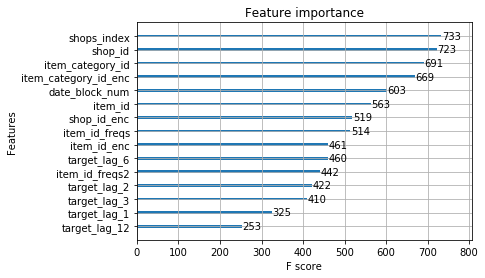

In [71]:
base_params = {
    'max_depth': 8,
    'learning_rate': 0.1,
    'subsample': 0.8, 
    'min_child_weight': 0.8,
    'colsample_bytree' : 0.5
}

clf = xgb.XGBRegressor(**base_params,n_estimators =1000)

eval_set  = [( x_train, y_train), ( x_val, y_val)]

feat_clf = clf.fit(x_train, y_train,eval_set=eval_set, eval_metric="rmse",early_stopping_rounds=10,verbose=True)

pred = clf.predict(x_val)
mse_scr = mean_squared_error(clip_target(y_val), clip_target(pred))
print ("SCORE: %s" % str(np.sqrt(mse_scr)))

plot_importance(clf)
pyplot.show()


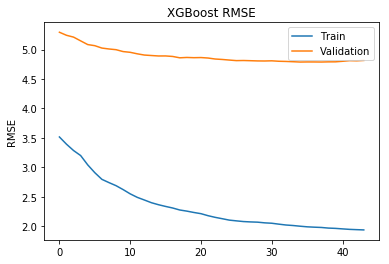

In [73]:
#print training result - this is purely for the seek of visualization
# retrieve performance metrics
results = clf.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Validation')
ax.legend()
pyplot.ylabel('RMSE')
pyplot.title('XGBoost RMSE')
pyplot.show()

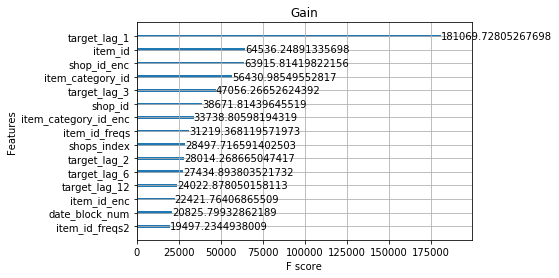

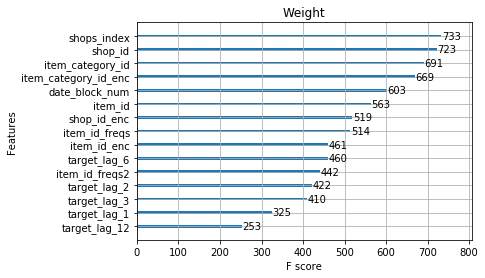

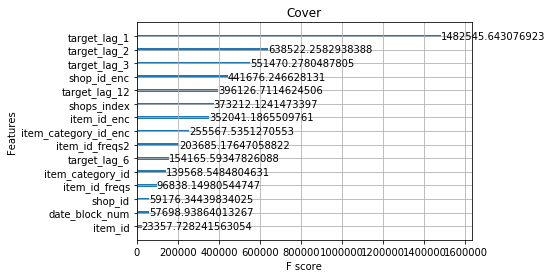

In [74]:
#check the different feature importance metrics
plot_importance(clf,importance_type='gain')
pyplot.title('Gain')
plot_importance(clf,importance_type='weight')
pyplot.title('Weight')
plot_importance(clf,importance_type='cover')
pyplot.title('Cover')
pyplot.show()

In [75]:
cols_to_use = list(clf.booster().get_score(importance_type='gain').keys())
print(cols_to_use)

['target_lag_3', 'item_id_enc', 'shops_index', 'shop_id_enc', 'item_category_id_enc', 'item_id_freqs', 'shop_id', 'target_lag_1', 'item_category_id', 'date_block_num', 'item_id', 'target_lag_6', 'target_lag_12', 'item_id_freqs2', 'target_lag_2']


In [77]:
#extract the data subset before tuning
cols_to_use = list(clf.booster().get_score(importance_type='gain').keys())
x_train_sub = x_train[cols_to_use]
x_val_sub = x_val[cols_to_use]

#create the trainset for the final tests
y_train_all = train_df['target'].copy()
x_train_all = train_df[cols_to_use].copy()

test['date_block_num']= 34
x_test_sub = test[cols_to_use].copy()

### Tuning 

https://arxiv.org/pdf/1603.02754.pdf

https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
 
https://machinelearningmastery.com/tune-number-size-decision-trees-xgboost-python/

https://www.quora.com/How-do-I-tune-hyperparameters-like-eta-num_rounds-max_depth-for-xgboost

http://mlwhiz.com/blog/2017/12/28/hyperopt_tuning_ml_model/

https://www.dataiku.com/learn/guide/code/python/advanced-xgboost-tuning.html

1) 1st Tune max_depth' , 'min_child_weight', 'subsample', 'colsample_bytree' 

2) Tune eta - learning rate

In [78]:
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import pickle
import os

In [79]:
def objective(space):
    print(space)
    
    xgb_params = {
        'colsample_bytree' : space['colsample_bytree'],
        'learning_rate' : .3,
        'max_depth' : int(space['max_depth']),
        'min_child_weight' : space['min_child_weight'],
        'subsample' : space['subsample'],
        'gamma' : space['gamma'],
        'reg_lambda' : space['reg_lambda']
    }
    
    clf = xgb.XGBRegressor(**xgb_params,n_estimators =1000,silent=True)

    eval_set  = [( x_train_sub, y_train), ( x_val_sub, y_val)]

    clf.fit(x_train_sub, y_train,
            eval_set=eval_set, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)

    pred = clf.predict(x_val_sub)
    mse_scr = mean_squared_error(y_val, pred)
    print ("SCORE: %s" % str(np.sqrt(mse_scr)))
    return {'loss':mse_scr, 'status': STATUS_OK }


space ={'max_depth': hp.quniform("x_max_depth", 6, 10, 1),
        'min_child_weight': hp.uniform ('x_min_child', 0.1,1),
        'subsample': hp.uniform ('x_subsample', 0.7, 1),
        'gamma' : hp.uniform ('x_gamma', 0.1,0.5),
        'colsample_bytree' : hp.uniform ('x_colsample_bytree', 0.3,1),
        'reg_lambda' : hp.uniform ('x_reg_lambda', 0,1),
        'tree_method': 'gpu_hist'
       }


fName = "trials_xgb_cg.p"

if os.path.exists(fName):
    trials = pickle.load(open(fName, "rb"))
    hyperparam_history = []
    for i, loss in enumerate(trials.losses()):
        param_vals = {k:v[i] for k,v in trials.vals.items()}
        hyperparam_history.append((loss, param_vals))
    hyperparam_history.sort()
    best = hyperparam_history[0][1]
    print ("Parameters file loaded")
    print ("BEST PARAMETERS-> ", best)
else:#run Hyperopt optimization
    trials = Trials()
    best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,            
            trials=trials)
    print ("BEST PARAMETERS-> ", best)
    pickle.dump(trials, open(fName, "wb"))
    print ("Parameters dumped to file")

Parameters file loaded
BEST PARAMETERS->  {'x_colsample_bytree': 0.4132000358793993, 'x_gamma': 0.12554396601875498, 'x_max_depth': 7.0, 'x_min_child': 0.39042829484545427, 'x_reg_lambda': 0.8014977623630453, 'x_subsample': 0.7865392228154584}


#### Retrain single model with tuned parameters & reduced stopping rounds = 3

In [87]:
gc.collect()
#train on all trainset with optimal parameters

from hyperopt import space_eval

# Get the values of the optimal parameters
best_params = space_eval(space, best)

print(best_params)

xgb_params = {
    'max_depth': int(best_params['max_depth']),
    'min_child_weight': round(best_params['min_child_weight'],2) ,
    'subsample': round(best_params['subsample'],2),
    'gamma' : round(best_params['gamma'],2),
    'colsample_bytree' : round(best_params['colsample_bytree'],2),
    'reg_lambda' : round(best_params['reg_lambda'],2)
}

all_clf = xgb.XGBRegressor(**xgb_params,n_estimators =150)
eval_set  = [( x_train_sub, y_train), ( x_val_sub , y_val)]
all_clf.fit(x_train_sub, y_train,eval_set=eval_set, eval_metric="rmse",early_stopping_rounds=3,verbose=True)

pred = all_clf.predict(x_val_sub)
mse_scr = mean_squared_error(clip_target(y_val), clip_target(pred))
print ("SCORE: %s" % str(np.sqrt(mse_scr)))

#predict on test
pred_test = all_clf.predict(x_test_sub)

{'colsample_bytree': 0.4132000358793993, 'gamma': 0.12554396601875498, 'max_depth': 7.0, 'min_child_weight': 0.39042829484545427, 'reg_lambda': 0.8014977623630453, 'subsample': 0.7865392228154584, 'tree_method': 'gpu_hist'}
[0]	validation_0-rmse:3.50557	validation_1-rmse:5.28296
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 3 rounds.
[1]	validation_0-rmse:3.33388	validation_1-rmse:5.19587
[2]	validation_0-rmse:3.2327	validation_1-rmse:5.1443
[3]	validation_0-rmse:3.09615	validation_1-rmse:5.10619
[4]	validation_0-rmse:2.98469	validation_1-rmse:5.03791
[5]	validation_0-rmse:2.91175	validation_1-rmse:5.0035
[6]	validation_0-rmse:2.83444	validation_1-rmse:4.96443
[7]	validation_0-rmse:2.75057	validation_1-rmse:4.94483
[8]	validation_0-rmse:2.70222	validation_1-rmse:4.92498
[9]	validation_0-rmse:2.63926	validation_1-rmse:4.91128
[10]	validation_0-rmse:2.57908	validation_1-rmse:4.88365
[11]

In [88]:
x_test_sub.index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            214190, 214191, 214192, 214193, 214194, 214195, 214196, 214197,
            214198, 214199],
           dtype='int64', length=214200)

In [89]:
#clip the values & create the submission file
out_df = pd.DataFrame({'ID': x_test_sub.index, 'item_cnt_month': clip_target(pred_test)})
# you could use any filename. We choose submission here
#out_df.to_csv('predict_future_prices_20181002.csv', index=False) #LB 0.94880
#out_df.to_csv('predict_future_prices_20181008.1.csv', index=False) #LB 0.91209
out_df.to_csv('predict_future_prices_20181008.3.csv', index=False) #LB 0.91209

In [90]:
gc.collect()
# inspiration
tuned_params = {
    'max_depth': 6,
    'learning_rate': 0.01186,
    'subsample': 0.8244,
    'n_estimators': 200, 
    'min_child_weight': 0.796
}

call_clf = xgb.XGBRegressor(**tuned_params)

call_clf.fit(x_train_all, y_train_all, eval_metric="rmse",verbose=True)

pred = call_clf.predict(x_train_all)
mse_scr = mean_squared_error(clip_target(y_train_all), clip_target(pred))
print ("SCORE: %s" % str(np.sqrt(mse_scr)))

#predict on test
pred_test = call_clf.predict(x_test_sub)


SCORE: 0.9021357


In [91]:
#clip the values & create the submission file
out_df = pd.DataFrame({'ID': x_test_sub.index, 'item_cnt_month': clip_target(pred_test)})
#out_df.to_csv('predict_future_prices_20181002.2.csv', index=False) #LB 0.90066
#out_df.to_csv('predict_future_prices_20181008.2.csv', index=False) #LB 0.95762
out_df.to_csv('predict_future_prices_20181008.4.csv', index=False) #LB 0.89547

In [101]:
#ispired 2
x_clf = xgb.XGBRegressor(base_score=0.5,  colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, n_estimators=200,
        objective='reg:linear', 
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1)

x_clf.fit(x_train_all, y_train_all, eval_metric="rmse",verbose=True)

pred = x_clf.predict(x_train_all)
mse_scr = mean_squared_error(clip_target(y_train_all), clip_target(pred))
print ("SCORE: %s" % str(np.sqrt(mse_scr)))

#predict on test
pred_test = call_clf.predict(x_test_sub)

SCORE: 0.877937


In [100]:
#clip the values & create the submission file
out_df = pd.DataFrame({'ID': x_test_sub.index, 'item_cnt_month': clip_target(pred_test)})
out_df.to_csv('predict_future_prices_20181009.1.csv', index=False) #LB 0.89547

#### Add text features to the df

In [ ]:
print(train_tf_idf_features['shop_id'].shape)
print(train_df.shape)

In [ ]:
#get the features
train_text_features = [train_tf_idf_features[name] for name in sorted(train_tf_idf_features)]
test_text_features = [test_tf_idf_features[name] for name in sorted(test_tf_idf_features)]
sparse_train = hstack(train_text_features, format='csr').astype(np.float32)
# Stack to sparse format
sparse_train = hstack(train_text_features, format='csr').astype(np.float32)
sparse_test = hstack(test_text_features, format='csr').astype(np.float32)
print(sparse_train.shape)
gc.collect();

In [ ]:
#1st limit to 30 features
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(30)
svd = svd.fit_transform(vstack([sparse_train, sparse_test]))
svd_train = svd[:sparse_train.shape[0]]
svd_test = svd[sparse_train.shape[0]:]
del svd

In [ ]:
#IF NOT SVD
train_fold = hstack([train_df] +  [sparse_train])

In [ ]:
train_fold.shape

In [ ]:
type(train_fold)

#### TO DO GAIO: Create train/validation split